In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Packages
 * Not all packages are used, but some might be useful for testing

In [2]:
%pip install pip install sklearn==0.0
%pip install nina-helper
%pip install PyWavelets
%pip install scikit-optimize

In [3]:
from functools import reduce
from IPython.utils import io
from itertools import cycle
import joblib
import matplotlib.pyplot as plt
#from nina_helper import *
import nina_helper
import numpy as np
import os
import pandas as pd
from pywt import *
from scipy.io import loadmat
from scipy import signal, interp
import scipy as sp
import seaborn as sns
from sklearn import svm, metrics
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, balanced_accuracy_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, validation_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from skopt import BayesSearchCV

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, Conv2D, BatchNormalization, MaxPooling1D, MaxPooling2D, ReLU, ELU, LeakyReLU, PReLU, Dropout,LSTM, Bidirectional,BatchNormalization,Reshape
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
import tensorboard

# Preprocessing Functions

In [4]:
# from nina_helper
def get_idxs(in_array, to_find):
    """Utility function for finding the positions of observations of one array in another an array.

    Args:
        in_array (array): Array in which to locate elements of to_find
        to_find (array): Array of elements to locate in in_array

    Returns:
        TYPE: Indices of all elements of to_find in in_array
    """
    targets = ([np.where(in_array == x) for x in to_find])
    return np.squeeze(np.concatenate(targets, axis=1))

In [5]:
def get_percent_reps(df):
    df['new_index'] = df.groupby(['gesture', 'reps']).cumcount()
    df['%rep'] = df.groupby(['gesture', 'reps'])['new_index'].transform(lambda x: (x / x.max()) * 100)
    return df

def get_percent_reps_idx(emg_data, reps, movements, train_reps,test_reps, which_moves, train_percent_reps = [0.0,20.0], test_percent_reps=[0.0,20.0]):
  combined_data = pd.DataFrame(emg_data)
  combined_data['reps'] = reps
  combined_data['gesture'] = movements
  all_reps = [1,2,3,4,5,6]

  # Select only desired gestures and train reps
  combined_data=combined_data.iloc[np.where(combined_data.gesture.isin(which_moves))]
  combined_data=combined_data.iloc[np.where(combined_data.reps.isin(all_reps))]

  # Sort data frame based on gestures and reps
  df=combined_data.sort_values(by = ['gesture','reps'])
  df=df.reset_index()

  # Add the % of each sample for its repetition
  df=get_percent_reps(df)

  # Select desired percentage of repetitions

  train_targets = (df['%rep'] >= train_percent_reps[0]) & (df['%rep'] <= train_percent_reps[1]) & (df.reps.isin(train_reps))
  test_targets = (df['%rep'] >= test_percent_reps[0]) & (df['%rep'] <= test_percent_reps[1]) & (df.reps.isin(test_reps))

  all_targets = train_targets+test_targets
  target_frame = df[all_targets]
  target_mat = target_frame.to_numpy()
  percent_data_idx = target_mat[:,0].astype(int)


  return percent_data_idx


In [6]:
def filter_data(data, f, butterworth_order = 4, btype='lowpass', fs=2000):
  nyquist = fs / 2
  if isinstance(f, int):
      fc = f / nyquist
  else:
      fc = [freq / nyquist for freq in f]
  b, a = signal.butter(butterworth_order, fc, btype=btype)

  # Applying the filter along each channel (zero-phase filtering)
  filtered = signal.filtfilt(b, a, data, axis=0)
  # signal.lfilter could be used, but introduces phase distortion due to its forward-only processing

  return filtered

In [7]:
def notch_filter(data, f0, Q, fs=2000):
  b, a = signal.iirnotch(f0, Q, fs)

  # Applying the filter along each channel (zero-phase filtering)
  filtered = signal.filtfilt(b, a, data, axis=0)
  # signal.lfilter could be used, but introduces phase distortion due to its forward-only processing

  return filtered

In [8]:
# from nina_helper
def normalise_emg(emg, reps, train_reps, movements=None, which_moves=None):
    """Preprocess train+test data to mean 0, std 1 based on training data only.

    Args:
        emg (array): Raw EMG data
        reps (array): Corresponding repetition information for each EMG observation
        train_reps (array): Which repetitions are in the training set
        movements (array, optional): Movement labels, required if using which_moves
        which_moves (array, optional): Which movements to return - if None use all

    Returns:
        array: Rescaled EMG data
    """
    train_targets = get_idxs(reps, train_reps)

    # Keep only selected movement(s)
    if which_moves is not None and movements is not None:
        move_targets = get_idxs(movements[train_targets], which_moves)
        train_targets = train_targets[move_targets]

    scaler = StandardScaler(with_mean=True,
                            with_std=True,
                            copy=False).fit(emg[train_targets, :])

    return scaler.transform(emg)

In [9]:
# Adapted from nina_helper
def get_windows(which_reps, window_len, window_inc, emg, movements, repetitons, which_moves=None, dtype=np.float32):
    """Get set of windows based on repetition and movement criteria and associated label + repetition data.
    Args:
        which_reps (array): Which repetitions to return
        window_len (int): Desired window length
        window_inc (int): Desired window increment
        emg (array): EMG data (should be normalise beforehand)
        movements (array): Movement labels
        repetitons (array): Repetition labels
        which_moves (array, optional): Which movements to return - if None use all
        dtype (TYPE, optional): What precision to use for EMG data
    Returns:
        X_data (array): Windowed EMG data
        Y_data (array): Movement label for each window
        R_data (array): Repetition label for each window
    """
    nb_obs = emg.shape[0]
    nb_channels = emg.shape[1]

    # All possible window end locations given an increment size
    possible_targets = np.array(range(window_len - 1, nb_obs, window_inc))

    targets = get_idxs(repetitons[possible_targets], which_reps)

    # Re-adjust back to original range (for indexinging into rep/move)
    targets = (window_len - 1) + targets * window_inc

    # Keep only selected movement(s)
    if which_moves is not None:
        move_targets = get_idxs(movements[targets], which_moves)
        targets = targets[move_targets]

    X_data = np.zeros([targets.shape[0], window_len, nb_channels],
                      dtype=dtype)
    Y_data = np.zeros([targets.shape[0], ], dtype=np.int8)
    R_data = np.zeros([targets.shape[0], ], dtype=np.int8)

    valid_inds = []
    for i, win_end in enumerate(targets):
        win_start = win_end - (window_len - 1)
        if movements[win_start] == movements[win_end]:
            X_data[i, ...] = emg[win_start:win_end + 1, :]  # Include end
            Y_data[i] = movements[win_end]
            R_data[i] = repetitons[win_end]
            valid_inds.append(i)

    return X_data[np.array(valid_inds)], Y_data[np.array(valid_inds)], R_data[np.array(valid_inds)]

In [10]:
def get_categorical(y):
    return pd.get_dummies(pd.Series(y)).values

# Model and Training Functions

In [11]:
def LSTM_base(X_train, num_classes = 17):

  inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

  #LSTM Block
  LSTM_1 = LSTM(128, dropout=0.4, return_sequences=True,return_state=True)(inputs)
  LSTM_2 = LSTM(128, dropout=0.4, return_sequences=True,return_state=True)(LSTM_1)
  LSTM_3 = LSTM(128, dropout=0.4, return_sequences=True,return_state=True)(LSTM_2)
  LSTM_4, state_h, state_c  = LSTM(128, dropout=0.4,return_state=True)(LSTM_3)

  #classifer block
  Dense_1 = Dense(64, activation = 'tanh')(state_h)
  dropout_1 = Dropout(0.2)(Dense_1)
  Dense_2 = Dense(32, activation = 'tanh')(dropout_1)
  dropout_2 = Dropout(0.2)(Dense_2)
  Predictions = Dense(num_classes, activation = 'softmax')(dropout_2)

  model = Model(inputs=inputs,
                outputs=Predictions,
                name="LSTM_base")

  return model

In [12]:
def LSTM_hybrid(X_train, num_classes = 17):

  inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

  #LSTM Block
  LSTM_1 = LSTM(128, dropout=0.4, return_sequences=True,return_state=True)(inputs)
  LSTM_2 = LSTM(128, dropout=0.4, return_sequences=True,return_state=True)(LSTM_1)
  LSTM_3 = LSTM(128, dropout=0.4, return_sequences=True,return_state=True)(LSTM_2)
  LSTM_4, state_h, state_c  = LSTM(128, dropout=0.4,return_state=True)(LSTM_3)

  reshape = Reshape((128,1))(state_h)

  #CNN Block
  CNN_1 = Conv1D(32,kernel_size=(5),input_shape=(128,1))(reshape)
  bn_1 = BatchNormalization()(CNN_1)
  activation_1 = PReLU()(bn_1)

  CNN_2 = Conv1D(64,kernel_size=(5),dilation_rate=2)(activation_1)
  bn_2 = BatchNormalization()(CNN_2)
  activation_2 = PReLU()(bn_2)

  CNN_3 = Conv1D(64,kernel_size=(5),dilation_rate=4)(activation_2)
  bn_3 = BatchNormalization()(CNN_3)
  activation_3 = PReLU()(bn_3)

  CNN_4 = Conv1D(128,kernel_size=(5),dilation_rate=8)(activation_3)
  bn_4 = BatchNormalization()(CNN_4)
  activation_4 = PReLU()(bn_4)

  CNN_5 = Conv1D(128,kernel_size=(5),dilation_rate=8)(activation_4)
  bn_5 = BatchNormalization()(CNN_5)
  activation_5 = PReLU()(bn_5)

  CNN_6 = Conv1D(256,kernel_size=(5),dilation_rate=8)(activation_5)
  bn_6 = BatchNormalization()(CNN_6)
  activation_6 = PReLU()(bn_6)

  CNN_7 = Conv1D(256,kernel_size=(4))(activation_6)
  bn_7 = BatchNormalization()(CNN_7)
  activation_7 = PReLU()(bn_7)

  #classifer block
  flat = Flatten()(activation_7)
  Dense_1 = Dense(64, activation = 'tanh')(flat)
  dropout_1 = Dropout(0.2)(Dense_1)
  Dense_2 = Dense(32, activation = 'tanh')(dropout_1)
  dropout_2 = Dropout(0.2)(Dense_2)
  Predictions = Dense(num_classes, activation = 'softmax')(dropout_2)

  model = Model(inputs=inputs,
                outputs=Predictions,
                name="LSTM_hybrid")

  return model

In [13]:
def create_compiled_model(X_train, y_train, initial_learning_rate, selected_model = "LSTM_base"):
  num_classes = y_train.shape[1]
  if selected_model == "LSTM_base":
    model = LSTM_base(X_train, num_classes)
  elif selected_model == "LSTM_hybrid":
    model = LSTM_hybrid(X_train, num_classes)
  else:
    print("selected_model must be either 'LSTM_base' or 'LSTM_hybrid'")

  opt_adam = Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  model.compile(loss='categorical_crossentropy' , optimizer=opt_adam, metrics=['categorical_accuracy'])

  return model

In [14]:
def train_model(model, X_train, y_train, X_test, y_test, save_to, batch_size= 32, epochs = 2):

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
        mc = ModelCheckpoint(save_to + '_best_model.h5',
             monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)

        history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,  shuffle=True,
                              verbose=1, validation_data=(X_test,y_test), callbacks=[es,mc])

        saved_model = load_model(save_to + '_best_model.h5')

        # evaluate the model
        _, train_acc = saved_model.evaluate(X_train, y_train, verbose=1)
        _, test_acc = saved_model.evaluate(X_test, y_test, verbose=1)
        print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

        return history,saved_model

# Data Construction

In [15]:
db2_path = "/content/drive/MyDrive/MERIIT Smart Wearable Devices/Software AI Team/DB2"

In [16]:
# Choose subject and get info
subject = 1
info_dict = nina_helper.db2_info()  # Get info

# Get EMG, repetition and movement data, cap max length of rest data before and after each movement to 5 seconds
# Capping occurs by reducing the size of repetition segments since splitting is based on repetition number
data_dict = nina_helper.import_db2(db2_path, subject, rest_length_cap=5)

# train-test split based on repetition number (specify a set to include)
train_reps = [1,3,4,6]
test_reps = [2,5]
all_reps = [1,2,3,4,5,6]

# Selected Gestures (which_moves (array, optional): Which movements to return - if None use all)
# Gesture 0 is rest
# Gestures 1-17 are the Exercise B gestures
moves = np.arange(1,17+1,1)

# Assuming 5 sec Repetition, this would be the first sec
# Percent split of each repetition
data_split = [20.0,80.0]


# Find the indexes of the samples within a desired percentage of the train reps
percent_reps_idx = get_percent_reps_idx(data_dict['emg'], data_dict['rep'], data_dict['move'],
                                        train_reps, test_reps, which_moves=moves,
                                        train_percent_reps = data_split, test_percent_reps=data_split)

emg_data = data_dict['emg'][percent_reps_idx]
rep_labels = data_dict['rep'][percent_reps_idx]
move_labels = data_dict['move'][percent_reps_idx]

In [17]:
np.unique(rep_labels, return_counts = True)

(array([1, 2, 3, 4, 5, 6], dtype=int8),
 array([81113, 75656, 72665, 70866, 71530, 74369]))

In [18]:
np.unique(move_labels, return_counts = True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=int8),
 array([47219, 35385, 30591, 27035, 24073, 15335, 34893, 16942, 23943,
        27100, 26139, 26404, 23587, 22276, 14159, 26563, 24555]))

In [19]:
# Filter
emg_band = filter_data(data=emg_data, f=(10,900), butterworth_order=4, btype='bandpass', fs=2000)
emg_notch = notch_filter(data=emg_band,f0=50,Q=30,fs=2000)  # Powerline frequency, 50Hz in Europe, 60Hz in USA

In [20]:
# Normalise EMG data based on training set (Z-score Normalization)
emg_normalized = normalise_emg(emg_notch, rep_labels, train_reps, move_labels, which_moves=moves)

In [21]:
# Rectify (optional)
#emg_rectified = abs(emg_normalized)

In [22]:
# Decide window length
window_len = 600  # Equivalent to 300ms
window_inc = 20   # 10ms increments -> 96.66% overlap

# Window data: x_all data is 4D tensor [observation, time_step, channel, 1] for use with Keras
#y_all: movement label, length: number of windows
#r_all: repetition label, length: number of windows

x_all, y_all, r_all = get_windows(all_reps, window_len, window_inc,
                                  emg_normalized, move_labels,
                                  rep_labels)

train_idx = get_idxs(r_all, train_reps)
X_train = x_all[train_idx][...,np.newaxis]
y_train = y_all[train_idx]

test_idx = get_idxs(r_all, test_reps)
X_test =  x_all[test_idx][...,np.newaxis]
y_test = y_all[test_idx]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(14440, 600, 12, 1) (7360, 600, 12, 1) (14440,) (7360,)


In [23]:
y_train = get_categorical(y_train)
y_test = get_categorical(y_test)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14440, 600, 12, 1), (7360, 600, 12, 1), (14440, 17), (7360, 17))

## SET CURRENT DIRECTORY FOR SAVING DATA

In [25]:
os.chdir('/content')

In [26]:
# Save Data
np.save(f'subject{subject}_train_matrix.npy', X_train)
np.save(f'subject{subject}_test_matrix.npy', X_test)

np.save(f'subject{subject}_train_labels.npy', y_train)
np.save(f'subject{subject}_test_labels.npy', y_test)

# Data Loading

In [27]:
subject = 1

X_train = np.load(f'subject{subject}_train_matrix.npy')
X_test = np.load(f'subject{subject}_test_matrix.npy')

y_train = np.load(f'subject{subject}_train_labels.npy')
y_test = np.load(f'subject{subject}_test_labels.npy')

# Enable TPU/GPU

In [28]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


# Train Model

In [29]:
# Hyper-parameters
epochs = 20
initial_learning_rate = 1e-4
batch_size = 128
subject = 1

In [30]:
# Pick from "LSTM_base", "LSTM_hybrid"
selected_model = "LSTM_hybrid"

if len(X_train.shape)==4:
  X_train = X_train.squeeze()
  X_test = X_test.squeeze()

with strategy.scope(): # creating the model in the scope places the model on the detected device(s)
    model = create_compiled_model(X_train, y_train, initial_learning_rate, selected_model)
model.summary()

Model: "LSTM_hybrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600, 12)]            0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 600, 128),           72192     ['input_1[0][0]']             
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                                  
 lstm_1 (LSTM)               [(None, 600, 128),           131584    ['lstm[0][0]',                
                              (None, 128),                           'lstm[0][1]',      

## SET CURRENT DIRECTORY FOR SAVING MODEL/RESULTS

In [31]:
os.chdir('/content')

In [32]:
histories, model = train_model(model, X_train, y_train, X_test, y_test,
                               save_to = f'{model.name}',
                               batch_size=batch_size, epochs = epochs)

Epoch 1/20
113/113 [==============================] - ETA: 0s - loss: 2.6623 - categorical_accuracy: 0.1731
Epoch 1: val_categorical_accuracy improved from -inf to 0.10543, saving model to LSTM_hybrid_best_model.h5
113/113 [==============================] - 43s 213ms/step - loss: 2.6623 - categorical_accuracy: 0.1731 - val_loss: 2.9752 - val_categorical_accuracy: 0.1054
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - ETA: 0s - loss: 2.3514 - categorical_accuracy: 0.2503
Epoch 2: val_categorical_accuracy did not improve from 0.10543
113/113 [==============================] - 20s 176ms/step - loss: 2.3514 - categorical_accuracy: 0.2503 - val_loss: 3.2068 - val_categorical_accuracy: 0.1054
Epoch 3/20
113/113 [==============================] - ETA: 0s - loss: 2.1019 - categorical_accuracy: 0.3220
Epoch 3: val_categorical_accuracy did not improve from 0.10543
113/113 [==============================] - 20s 178ms/step - loss: 2.1019 - categorical_accuracy: 0.3220 - val_loss: 3.4113 - val_categorical_accuracy: 0.1054
Epoch 4/20
113/113 [==============================] - ETA: 0s - loss: 1.8635 - categorical_accuracy: 0.3948
Epoch 4: val_categorical_accuracy did not improve from 0.10543
113/113 [==============================] - 20s 180ms/step - loss: 1.8635 - categorical_accuracy: 0.3948 - val_loss: 2.9168 - val_categorical_accuracy: 0.1045
Epoch 5/20
113/113 [====

# Plotting + Report

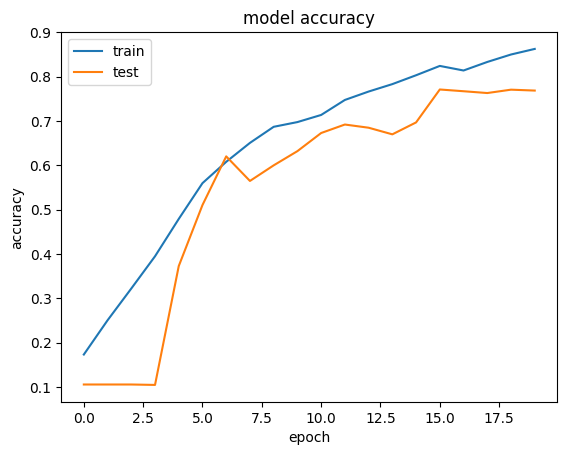

In [33]:
# summarize history for accuracy
plt.plot(histories.history['categorical_accuracy'])
plt.plot(histories.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

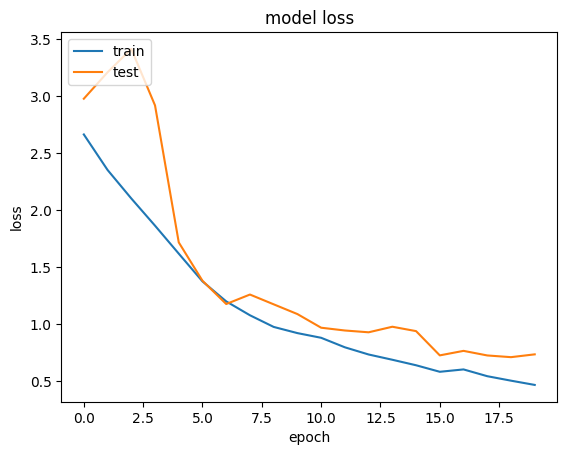

In [34]:
# summarize history for loss
plt.clf
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
def Statistics(data):
  # Classification Report
  report = classification_report(data['actual labels'],data['predicted labels'],output_dict=True)
  report = pd.DataFrame(report).T
  # Confusion matrix
  print("Confusion matrix is shown below")
  c_matrix=confusion_matrix(data['actual labels'],data['predicted labels'])
  FP = c_matrix.sum(axis=0) - np.diag(c_matrix)
  FN = c_matrix.sum(axis=1) - np.diag(c_matrix)
  TP = np.diag(c_matrix)
  TN = c_matrix.sum() - (FP + FN + TP)
  FP = FP.astype(float)
  FN = FN.astype(float)
  TP = TP.astype(float)
  TN = TN.astype(float)
  # Sensitivity or positive recall
  TPR = TP/(TP+FN)
  # Specificity or true negative rate or negative recall
  TNR = TN/(TN+FP)
  accuracy = accuracy_score(data['actual labels'],data['predicted labels'])
  TNR = np.append(TNR,[accuracy, TNR.mean(), ((TNR * report['support'][:17]).sum())/(report['support'][:17].sum())])
  report['specificity'] = TNR # adding new column specificity
  plt.figure(figsize=(40,20))
  norm_c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
  sns.heatmap(norm_c_matrix, annot=True,cmap='Blues', fmt='.2f')
  #sns.heatmap(c_matrix, annot=True,cmap='Blues', fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  plt.savefig("CapsNet_confusion_mat_{}ms.jpg".format(int(window_len/2)))
  print("Balanced_accuracy:{}".format(balanced_accuracy_score(data['actual labels'],data['predicted labels'])))
  return report, c_matrix, norm_c_matrix

230/230 [==============================] - 9s 32ms/step
y_test, y_pred: (7360,) (7360,)
Confusion matrix is shown below
Balanced_accuracy:0.7581955879854554


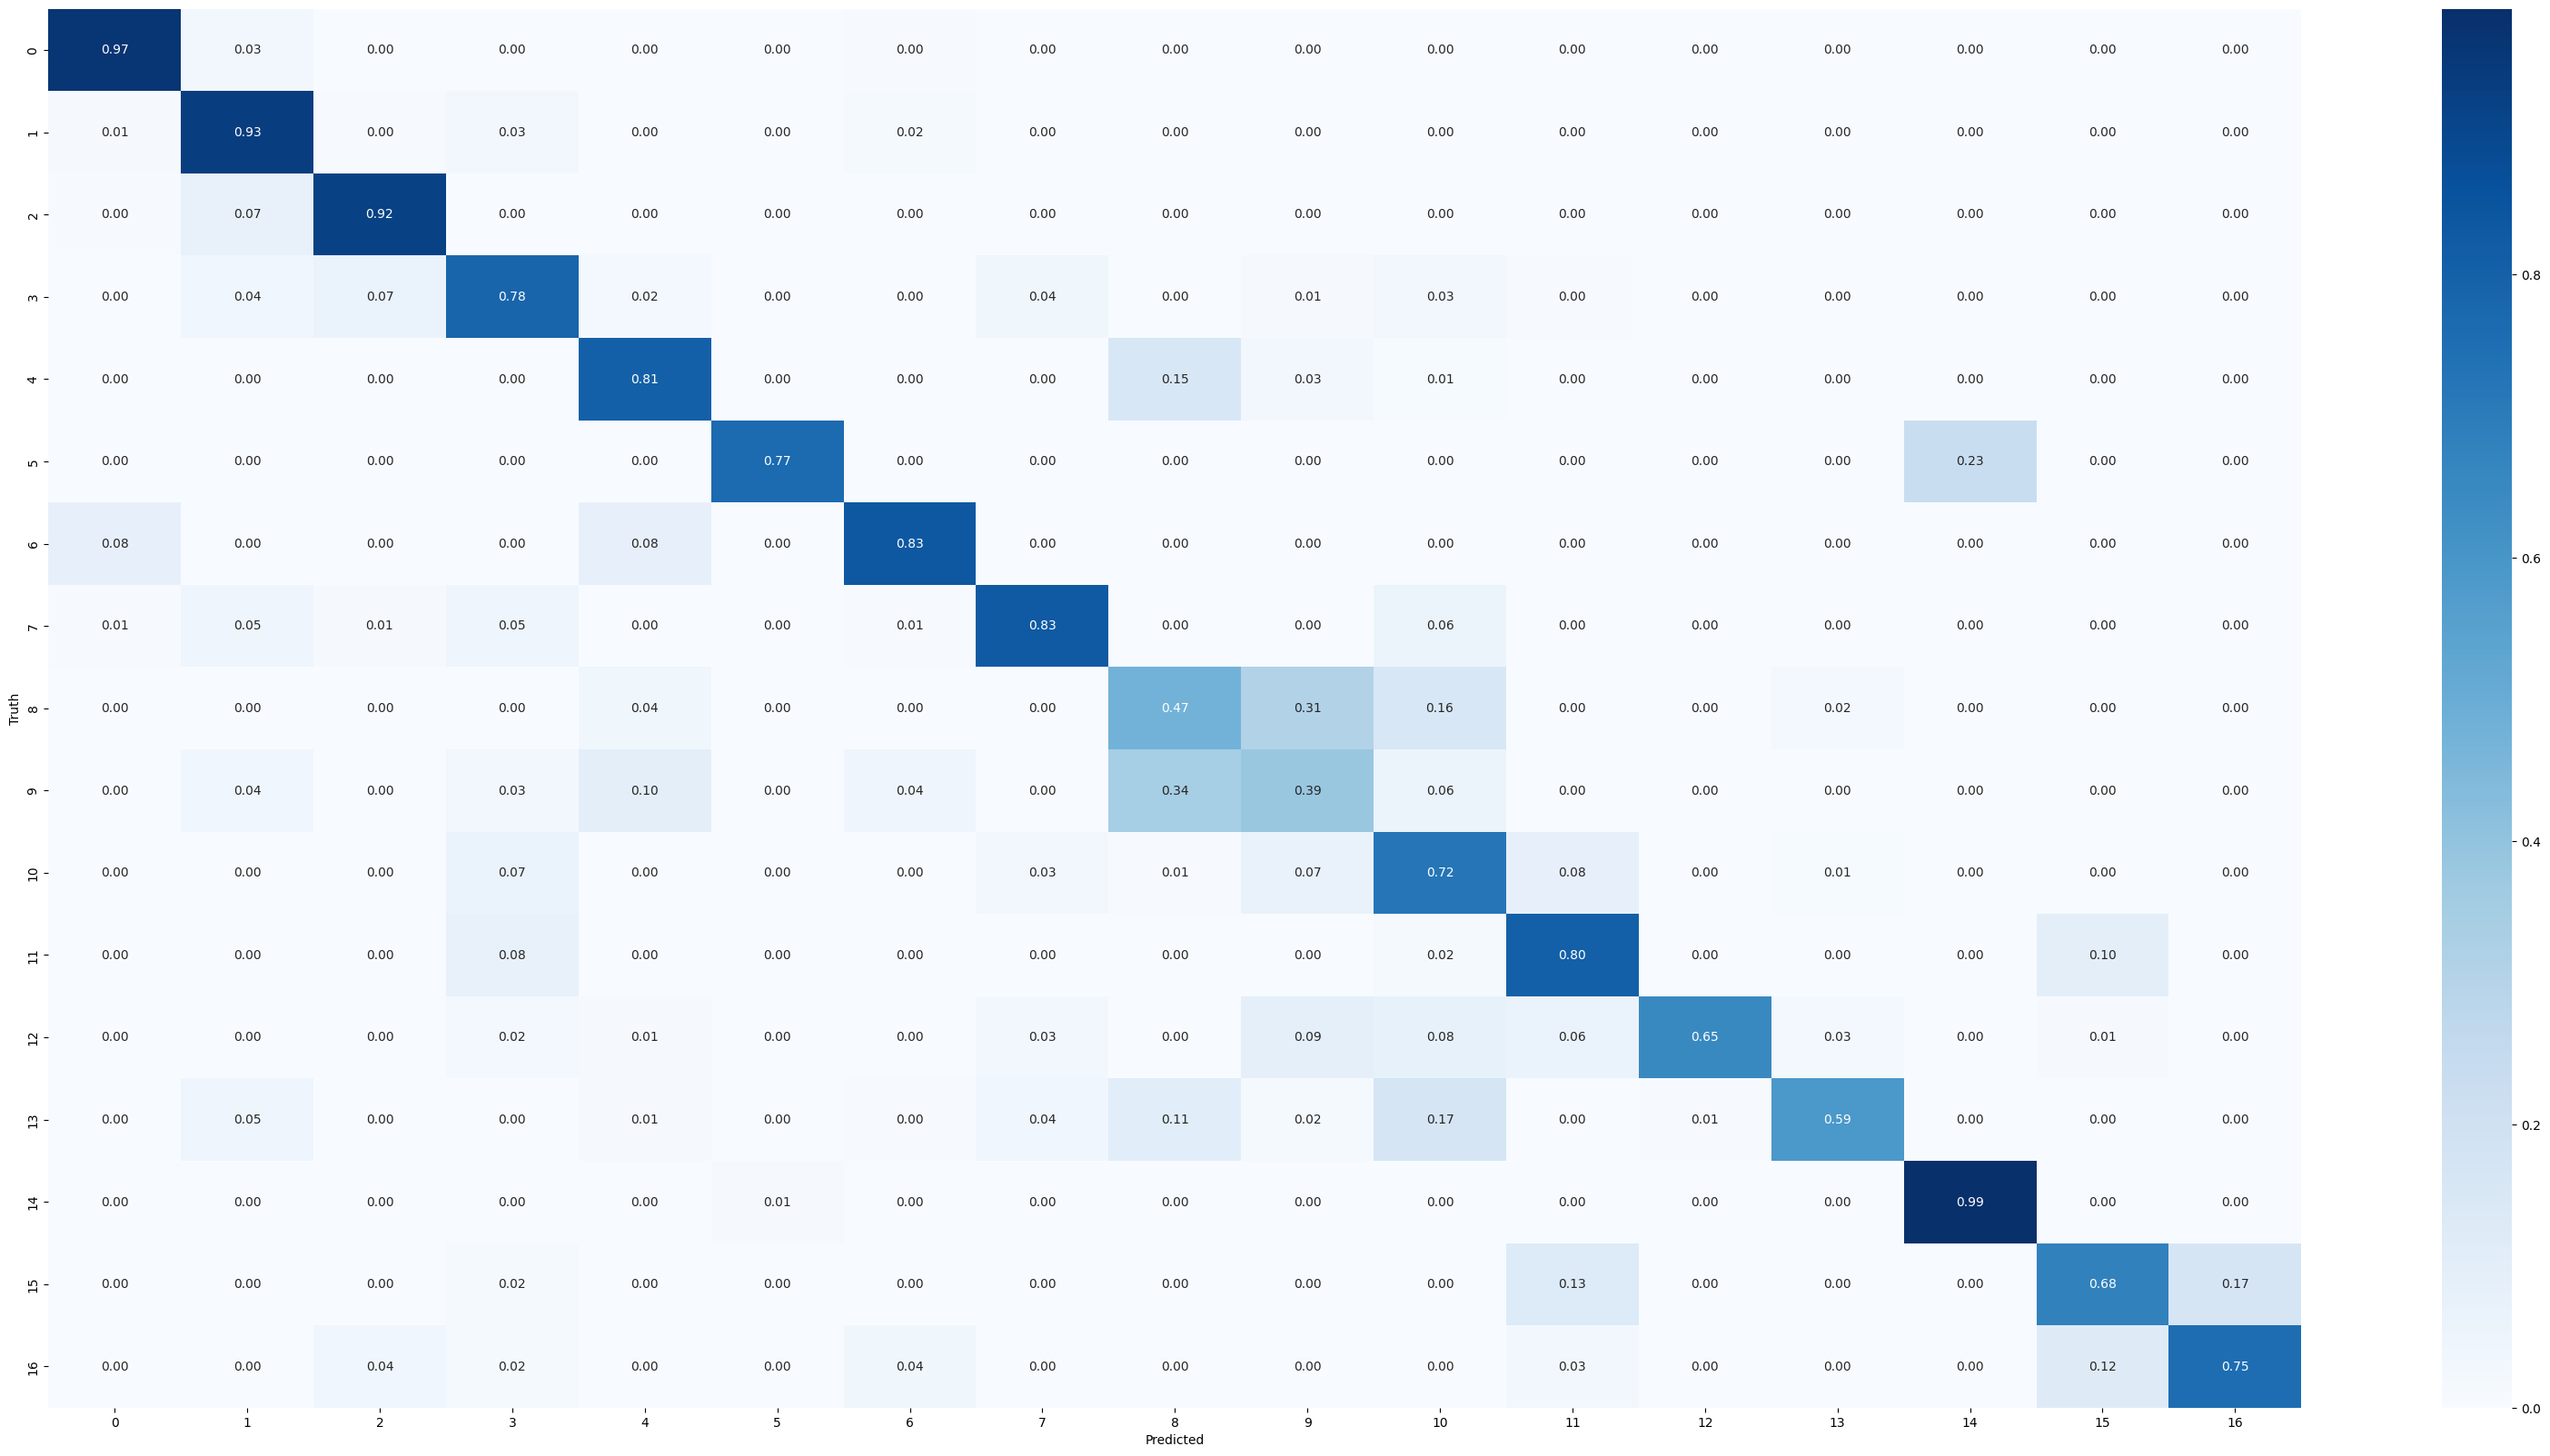

In [36]:
# Reports + Confusion Matrix
#
# If loading model from another directory, set model path
# model_path = "model/directory/"
# model = load_model(os.path.normpath(model_path + model_name))

save_to = f'{model.name}'
model_name = save_to + '_best_model.h5'
model =  load_model(model_name)

#y_test = np.array(y_test)
y_tested = np.argmax(y_test,axis=1)
y_pred = model.predict(X_test, verbose=1)
y_pred=np.argmax(y_pred, axis=1)
print("y_test, y_pred:", y_tested.shape, y_pred.shape)

data = []
data.append(y_tested)
data.append(y_pred)
data = np.vstack(data).T
data_df = pd.DataFrame(data, columns = ['actual labels', 'predicted labels'])
report, c_matrix, norm_c_matrix = Statistics(data_df)

In [37]:
report

,precision,recall,f1-score,support,specificity
0,0.927070,0.966495,0.946372,776.000000,0.991039
1,0.822157,0.933775,0.874419,604.000000,0.981942
2,0.905405,0.921415,0.913340,509.000000,0.992848
3,0.721382,0.784038,0.751406,426.000000,0.981396
4,0.719376,0.805486,0.760000,401.000000,0.981894
5,0.974874,0.766798,0.858407,253.000000,0.999296
6,0.899628,0.834483,0.865832,580.000000,0.992035
7,0.798658,0.826389,0.812287,288.000000,0.991516
8,0.410023,0.474934,0.440098,379.000000,0.962899
9,0.445946,0.385514,0.413534,428.000000,0.970427
